# Cutting a stick of length 1 into n pieces
- If n is fixed, we can actually show that the distribution of the lengths of the pieces is a beta distribution with parameters 1 and n-1.
- If n is large enough, beta(1, n-1) is approximately an exponential distribution with rate n. --> I proved this so far only through showing that the first and second moments (E(x) and e(x^2)) of the two distributions are the same as n--> infinity.
-  Paper Tenchov et al. 1985 states that P(X<=x) = 1 - (1-x)^n, which is the CDF of the exponential distribution with rate n. Why? I still have to prove this. Well, the CDF of the exponential(rate=n) is 1 - e^(-nx), which is the same as 1 - (1-x)^n.

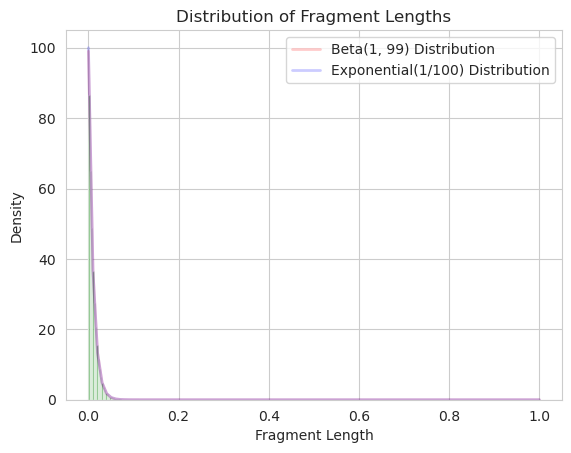

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import expon
def simulate_fragmentation(n, simulations=1000):
    fragment_lengths = []
    for _ in range(simulations):
        break_points = np.random.rand(n-1)
        break_points = np.append(break_points, [0, 1])
        break_points.sort()
        lengths = np.diff(break_points)
        fragment_lengths.extend(lengths)
    return fragment_lengths

# Simulate fragmentation into 5 parts, 10000 times
n = 100
fragment_lengths = simulate_fragmentation(n, simulations=10000)

# plot the beta distribution
x = np.linspace(0, 1, 100)
y = beta.pdf(x, 1, n-1)
plt.plot(x, y, 'r-', lw=2, label=f'Beta(1, {n-1}) Distribution', alpha =0.2)

# plot the exponential distribution
x = np.linspace(0, 1, 100)
y = expon.pdf(x, scale=1/n)
plt.plot(x, y, 'b-', lw=2, label=f'Exponential(1/{n}) Distribution', alpha=0.2)

# Plot the distribution of fragment lengths
plt.hist(fragment_lengths, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution of Fragment Lengths')
plt.xlabel('Fragment Length')
plt.ylabel('Density')
plt.legend()
plt.show()


# Draw the distribution of fragment lengths for different molecules from the same set up of genes and expression
- Fragments produced by the Weilbull distribution procedure
- Fragments produced by the exponential distribution procedure

# given the molecule of a certain fixed length, would the two methods produce different fragment lengths distribution?
- Across all fragments
- Only the first fragment of the gene

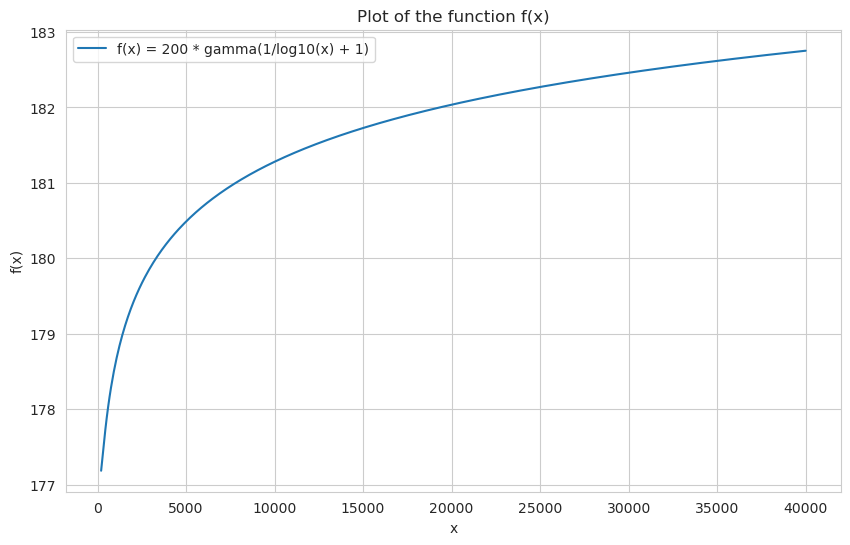

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
# based on Tenchov et al, 1985, the expected value of Xis d_0 + \nu * Gamma(1/delta +1), where \nu is 200 in our case (average read length?), and delta is the shape parameter of the Weilbull distribution, which is log10(length of the molecule) based on 'empirical' use from the Flux Simulator. In our case, d_0 is always 0 because it is the smallest value of fragment length.
# we will plot the average fragment length given varying values of molecules
# Define the function
eta_val = 200
def expected_fragLen_weibull(x):
    delta = np.log10(x)
    return 200 * gamma(1/delta  + 1)

# Generate x values from 1 to 10, excluding values close to 0 to avoid infinity or undefined values
x = np.linspace(200, 40000, 500)

# Compute y values
y = expected_fragLen_weibull(x)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='f(x) = 200 * gamma(1/log10(x) + 1)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of the function f(x)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# draw the distribution of fragment lengths for different molecules of varying lengths and how it overlaps with the Weibull distribution
# the point of this plot is to understand that the way we simulate from Weibull distribution is correct? 
# conclusion: It does not look very close to me that the distribution are completely concurrent, but this question is not the main point of my analysis
from transcription import simulate_reads_from_transcripts as srt
DEFAULT_ETA = 200
DEFAULT_REPLICATE = 1000
def simulate_fragLen_Weibull(x, eta_val=DEFAULT_ETA, replicate=DEFAULT_REPLICATE, first_only=False):
    """

    :param x: length of the molecule
    :param eta_val:
    :param replicate:
    :return:
    """
    all_frag_lengths = []
    for _ in range(replicate):
        frag_length, frag_start = srt.calculate_breakpoints_weilbull_fragment(x, eta_val=eta_val, avg_frag_len=-1) # we wont use avg_frag_len in this function
        if first_only:
            all_frag_lengths.append(frag_length[0])
        else:
            all_frag_lengths.extend(frag_length)
    return np.array(all_frag_lengths)


def simulate_fragLen_uniform(x, avg_frag_len=None, replicate=DEFAULT_REPLICATE, first_only=False):
    """
    first_only: if True, only return the first fragment of the gene so we will have replicate number of fragments returned
    """
    if avg_frag_len == None:
        avg_frag_len = expected_fragLen_weibull(
            x)  # want to replicate the mean fragment length generated from Weibull distribution
    all_frag_lengths = []
    for i in range(replicate):
        frag_length, frag_start = srt.calculate_breakpoints_uniform_fragment(x, eta_val=-1, avg_frag_len=avg_frag_len)  # we wont use eta_val in this function
        if first_only:
            all_frag_lengths.append(frag_length[0])
        else:
            all_frag_lengths.extend(frag_length)
    return np.array(all_frag_lengths)
    
        
def draw_weibull_distribution(x, eta_val=DEFAULT_ETA):
    from scipy.stats import weibull_min
    frag_lengths = []
    scale = eta_val
    shape = np.log10(x)
    # Generate x values
    x = np.linspace(weibull_min.ppf(0.001, shape, scale=scale),weibull_min.ppf(0.999, shape, scale=scale), 100)
    # Calculate the pdf
    pdf_values = weibull_min.pdf(x, shape, scale=scale)
    # calculate the probabilty that the fragment length is less than 300 and greater than 200
    cdf_300 = weibull_min.cdf(300, shape, scale=scale)
    cdf_200 = weibull_min.cdf(200, shape, scale=scale)
    prob = cdf_300 - cdf_200
    print('Prob. that the fragment length is between 200 and 300:', prob)
    return x, pdf_values, prob

def draw_exponential_distirbution(x, avg_frag_len=None):
    if avg_frag_len == None:
        avg_frag_len = expected_fragLen_weibull(x)  # replicate the mean of the fragment length generated from Weibull distribution
    from scipy.stats import expon
    x = np.linspace(expon.ppf(0.001, scale=avg_frag_len), expon.ppf(0.999, scale=avg_frag_len), 100)
    pdf_values = expon.pdf(x, scale=avg_frag_len)
    return x, pdf_values


So far we have established that our implementation of the Weibull distribution is correct, or correct enough. However the results so far only shows the distribution of fragment length for one fixed length. I would also want to see how the distribution can change if the length of the molecule changes.
First, draw a plot of overlapping two histograms showing the fragment length distribution of two molecules of different lengths.
Second, draw a grid of plots showing the hisrogram of fragment length distribution of different molecules of different lengths.

Prob. that the fragment length is between 200 and 300: 0.3663181340181646


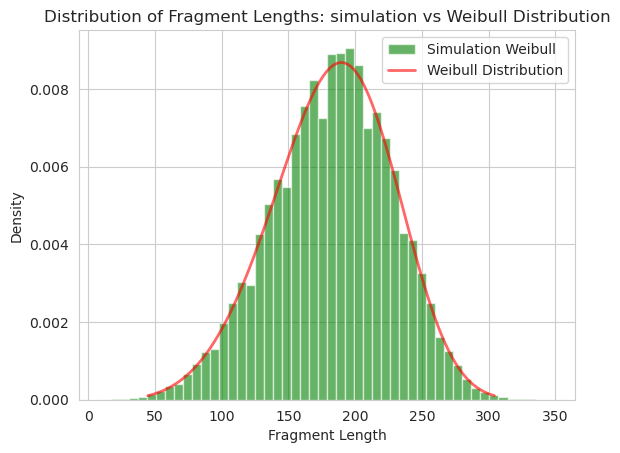

In [8]:
fragLen, pdf_values, _ = draw_weibull_distribution(40000)
fragLen_list_weibull = simulate_fragLen_Weibull(40000)
plt.hist(fragLen_list_weibull, bins=50, density=True, alpha=0.6, color='g', label='Simulation Weibull')
plt.plot(fragLen, pdf_values, 'r-', lw=2, label='Weibull Distribution', alpha=0.6)
plt.title('Distribution of Fragment Lengths: simulation vs Weibull Distribution')
plt.xlabel('Fragment Length')
plt.ylabel('Density')
plt.legend()
plt.show()

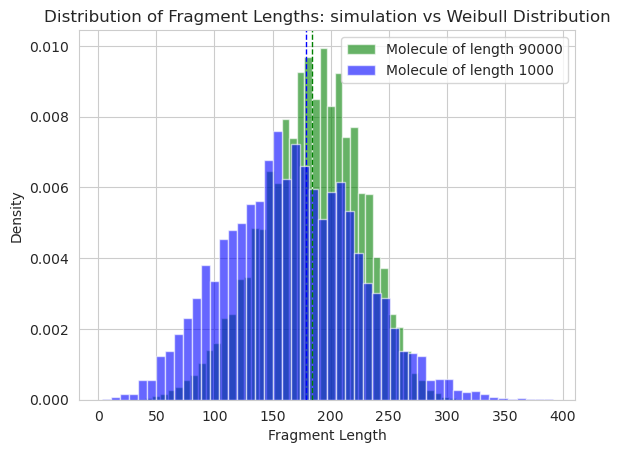

In [9]:
long_fragLen = 90000
short_fragLen = 1000
fragLen_list1 = simulate_fragLen_Weibull(long_fragLen)
fragLen_list2 = simulate_fragLen_Weibull(short_fragLen)
plt.hist(fragLen_list1, bins=50, density=True, alpha=0.6, color='g', label='Molecule of length 90000')
plt.hist(fragLen_list2, bins=50, density=True, alpha=0.6, color='b', label='Molecule of length 1000')
# plot the two vertical lines corresponding to the expected value of the fragment length
plt.axvline(expected_fragLen_weibull(long_fragLen), color='g', linestyle='dashed', linewidth=1)
plt.axvline(expected_fragLen_weibull(short_fragLen), color='b', linestyle='dashed', linewidth=1)
plt.title('Distribution of Fragment Lengths: simulation vs Weibull Distribution')
plt.xlabel('Fragment Length')
plt.ylabel('Density')
plt.legend()

Prob. that the fragment length is between 200 and 300: 0.33366132285977634
Prob. that the fragment length is between 200 and 300: 0.3565551759004688
Prob. that the fragment length is between 200 and 300: 0.3615497257439566
Prob. that the fragment length is between 200 and 300: 0.3645987693956485
Prob. that the fragment length is between 200 and 300: 0.3663181340181646
Prob. that the fragment length is between 200 and 300: 0.36720467902448206


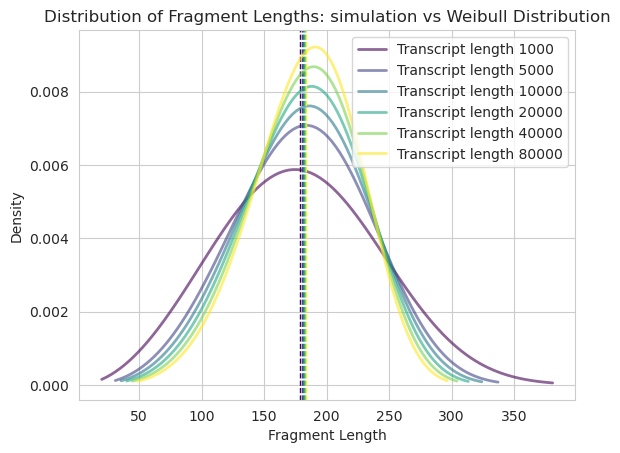

In [11]:
lengths = [1000, 5000, 10000, 20000, 40000, 80000]
# color map such that longer length will have a darker color
colors = plt.cm.viridis(np.linspace(0, 1, len(lengths)))
# plot the weibull distribution for each length, all on the same plot such that the color of the line corresponds to the length of the molecule
for i, length in enumerate(lengths):
    fragLen, pdf_values, _ = draw_weibull_distribution(length)
    max_quantile_len = fragLen[-1]  # the last values in max_quantile_len is the value of the x axis in weibull distribution where the cdf is 0.999
    plt.plot(fragLen, pdf_values, color=colors[i], lw=2, label=f'Transcript length {length}', alpha=0.6)
    plt.axvline(expected_fragLen_weibull(length), color=colors[i], linestyle='dashed', linewidth=1)
    # plt.axvline(max_quantile_len, color=colors[i], linestyle='dotted', linewidth=1)
    
plt.title('Distribution of Fragment Lengths: simulation vs Weibull Distribution')
plt.xlabel('Fragment Length')
plt.ylabel('Density')
plt.legend()
plt.show()

What we observed is that the longer the length of the molecules, the flatter the distribution of the fragment lengths. 
However, the expected value of the fragment length is not too qualitatively different across different lengths of the molecules.
But what we also learn is that if we keep the way the simulation is done as of right now, we will end up throwing away half the fragments in the size-selection step where we only keep fragments that are 200-300bp long. 

# Now, can we design another way to simulate the fragment lengths such that we can also mimic the phenomenon of edge effects?
Can I find a distribution that will give me the a histogram that looks almost like Weilbull distribution?
- Poisson is not correct
- Can we simulate uniform fragmentation and compare the distribution of fragment lengths with the Weilbull distribution?

Prob. that the fragment length is between 200 and 300: 0.3663181340181646


ValueError: too many values to unpack (expected 2)

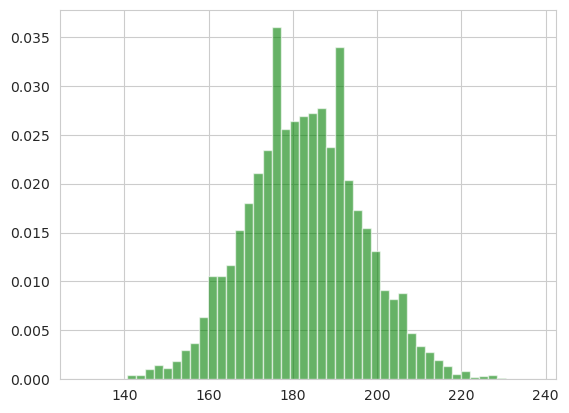

In [13]:
# first, the choice cannot be a poisson distribution. 
length=40000
mean = expected_fragLen_weibull(length)
fragLen_list = np.random.poisson(mean, 10000)
plt.hist(fragLen_list, bins=50, density=True, alpha=0.6, color='g', label='Poisson histogram')
# plot the weibull distribution for the same molecule length in the same plot
fragLen, pdf_values = draw_weibull_distribution(length)
plt.plot(fragLen, pdf_values, 'r-', lw=2, label='Weibull Distribution', alpha=0.6)
plt.title('Distribution of Fragment Lengths: Poisson vs Weibull Distribution')
plt.xlabel('Fragment Length')
plt.ylabel('Density')
plt.legend()
plt.show()

# Investigation of uniform fragmentation
- Does uniform fragmentation give us a distribution that looks like the Weibull distribution? No
- Does uniform fragmentation create the edge effect?
- Does uniform fragmentation changes the read coverage the the middle of the gene? 

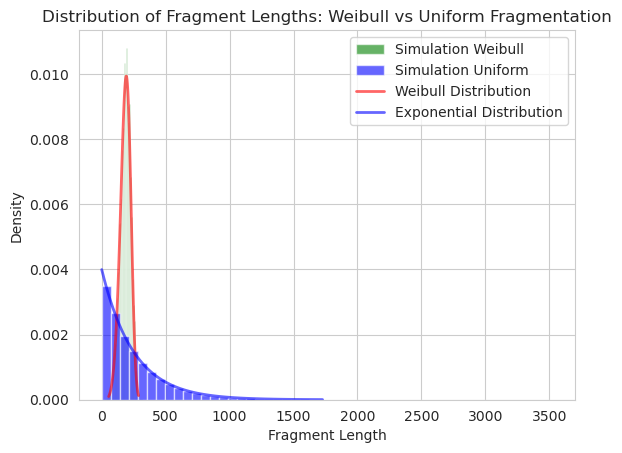

In [10]:
# does uniform fragmentation gives us a distribution that looks like the Weibull distribution?
import importlib
importlib.reload(srt)
mol_length = 200000
fragLen_weibull, pdf_weibull = draw_weibull_distribution(mol_length)
fragLen_exp, pdf_exp = draw_exponential_distirbution(mol_length, avg_frag_len=250)
fragLen_list_weibull = simulate_fragLen_Weibull(mol_length)
fragLen_list_uniform = simulate_fragLen_uniform(mol_length, avg_frag_len=250)
plt.hist(fragLen_list_weibull, bins=50, density=True, alpha=0.6, color='g', label='Simulation Weibull')
plt.hist(fragLen_list_uniform, bins=50, density=True, alpha=0.6, color='b', label='Simulation Uniform')
plt.plot(fragLen_weibull, pdf_weibull, 'r-', lw=2, label='Weibull Distribution', alpha=0.6)
plt.plot(fragLen_exp, pdf_exp, 'b-', lw=2, label='Exponential Distribution', alpha=0.6 )
plt.title('Distribution of Fragment Lengths: Weibull vs Uniform Fragmentation')
plt.xlabel('Fragment Length')
plt.ylabel('Density')
plt.legend()
plt.show()

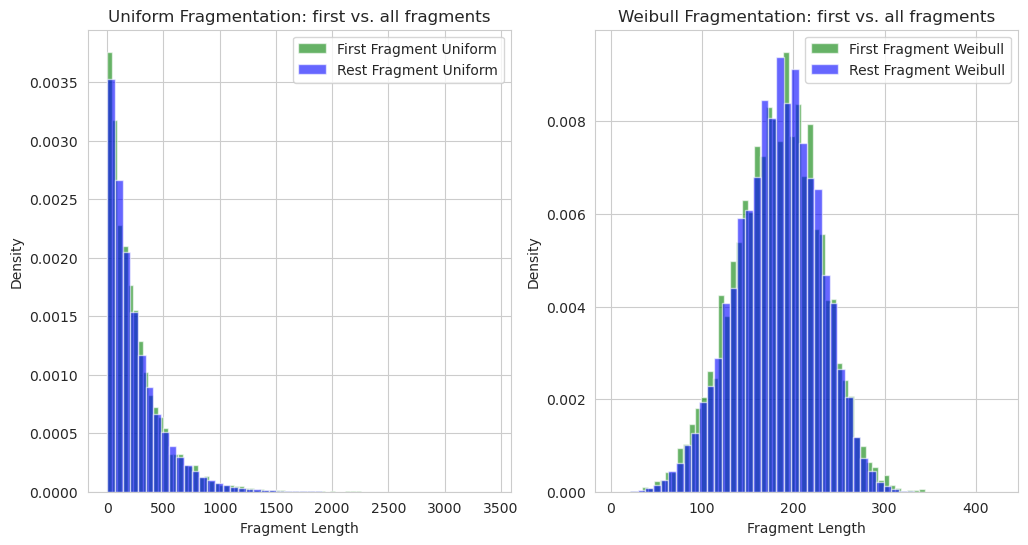

In [11]:
# does uniform fragmentation create the edge effect? MAYBE?????
# We will do the following:
# Simulate the data for molecules of variable length, ranging from 1000 to 80000
# For each molecule length, we will simulate the fragment lengths using the Weibull distribution and the uniform distribution
# We will plot the distribution of fragment lengths for each molecule length, across all the spectrum of molecule lengths
avg_frag_len = 250
replicate = 10000
mol_lengths = np.random.randint(1000, 80000, replicate)
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) # one plot for uniform fragmentation, one plot for Weibull fragmentation
unif_vf = np.vectorize(simulate_fragLen_uniform, signature='(),(),(),()->(n)')
weibull_vf = np.vectorize(simulate_fragLen_Weibull)
first_unif_len = unif_vf(mol_lengths, avg_frag_len=avg_frag_len, replicate=1, first_only=True).reshape(-1)
rest_unif_len = np.concatenate([simulate_fragLen_uniform(x, avg_frag_len=avg_frag_len, replicate=1, first_only=False) for x in mol_lengths])
first_weibull_len = weibull_vf(mol_lengths, replicate=1, first_only=True).reshape(-1)
rest_weibull_len = np.concatenate([weibull_vf(x, replicate=1, first_only=False) for x in mol_lengths])

ax[0].hist(first_unif_len, bins=50, density=True, alpha=0.6, color='g', label='First Fragment Uniform')
ax[0].hist(rest_unif_len, bins=50, density=True, alpha=0.6, color='b', label='Rest Fragment Uniform')
ax[0].set_title('Uniform Fragmentation: first vs. all fragments')
ax[0].set_xlabel('Fragment Length')
ax[0].set_ylabel('Density')
ax[0].legend()
ax[1].hist(first_weibull_len, bins=50, density=True, alpha=0.6, color='g', label='First Fragment Weibull')
ax[1].hist(rest_weibull_len, bins=50, density=True, alpha=0.6, color='b', label='Rest Fragment Weibull')
ax[1].set_title('Weibull Fragmentation: first vs. all fragments')
ax[1].set_xlabel('Fragment Length')
ax[1].set_ylabel('Density')
ax[1].legend()
plt.show()

Moment of truth: Visualize the read coverage across the gene for the uniform fragmentation and the Weibull fragmentation. What I would like to answer is:
- Is there edge effect? No, absolutely note. In fact, there is pronounced phenomenon of a spike in read coverage at the beginning of the gene for both method.
- Are there stark difference between the two fragmentation methods in terms of read coverage for different methods? Yes, the read coverage from uniform fragmentation is much lower across the gene compared to the Weibull fragmentation.
- What is the probability that the fragments pass length filter given different ways of fragmentation simulation? 

In [4]:
import os
print(os.getcwd())
os.chdir('/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations')
import numpy as np
import visualize_simulations as viz
import matplotlib.pyplot as plt
from transcription import simulate_multiple_experiments as sim
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
import helper

ONE_KB=1000
SIM_FEAT_LEN = 5000 # length of one feature in the simulation
SEED = 9999
np.random.seed(SEED)
target_exp = 5
num_total_transcript_millions = 100
degrade_rate = 0.00
intron_h = 5
PAS_h=5
RTR=500
lambda_init = 2 # average number of burst events per minute (burst event is the event where a burst_size transcripts are created around the same time)
burst_size = 10 # number of transcripts created in a burst event
wiggle_room = 0.3 # the wiggle room for the burst event. See the comments in function Experiment.init_bursting_transcripts to understand the meaning of this parameter. If not sure, don't modify it.
# if I want to simulate situation such that there is no read being generated from fragments (only the whole transcripts are sequenced), the following parameters should be set carefully:
eta_val=helper.DFT_ETA_VALUE  # the scale fo weibull distribution for the fragment length
insertsize_min = 200  #filter fragments minimum length
insertsize_max = 300  # filter fragments maximum length
read_length = 150 # the length of the reads
frag_func= 'weibull' # whether we will simulate the fragmentation of transcripts based on the weibull distribution or the uniform fragmentation method
unif_avg_frag_len=250 # the desired average fragment length if we use the uniform fragmentation method
# if I set the read values to -1, the program will just generate fragments and not get rid of any portion of the fragments.
simulate_cleavage=False ## for this problem, we don't need to simulate cleavage because we really only care about calculating the elongation speed of the transcripts. We skip splicing and cleavage for now.
PDB = True  # whether we simulate a system where there is no existing transcripts, and instead we used PDB to stop the transcripts from elongation, and let the elongation to start PDB_time minutes before we introduce the first tag
label_time = [0 ,5,10, 15] if PDB else [0,5,10]
num_timepoints = len(label_time)
max_time_for_equilibrium = 50
save_folder = None # './exon2_4Fold/'
gtf_df = sim.create_variable_gtf_df(nExons=3, elong_fold_list = [1,1,1,1,1], length_fold_list = [5,5,5,5,5], SIM_FEAT_LEN=ONE_KB)
gtf_df = gtf_df[gtf_df['is_intron'] == False]
gtf_df['start'] = gtf_df.loc[0, 'start'] + np.cumsum(gtf_df['length']) - gtf_df['length']
gtf_df['end'] = gtf_df['start'] + gtf_df['length']
gtf_df['time'] = (gtf_df['end'] - gtf_df['start']) / gtf_df['txrate'] / ONE_KB  # time to traverse the feature

/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations
importing simulate_multiple_experiments


In [6]:
weibull_exp_list = sim.generate_exp_given_one_gtf(gtf_df, save_folder= save_folder, label_time = label_time, target_exp=target_exp, num_total_transcript_millions = num_total_transcript_millions, lambda_init = lambda_init , burst_size = burst_size, wiggle_room = wiggle_room,eta_val=eta_val, insertsize_min=insertsize_min, insertsize_max=insertsize_max, frag_func='weibull_edge', unif_avg_frag_len=unif_avg_frag_len, read_length=read_length, simulate_cleavage=simulate_cleavage, PDB=PDB, max_time_for_equilibrium=max_time_for_equilibrium)

inside generate_exp_given_one_gtf
before adding new experiments
0
150
270
380


In [5]:
unif_exp_list = sim.generate_exp_given_one_gtf(gtf_df, save_folder= save_folder, label_time = label_time, target_exp=target_exp, num_total_transcript_millions = num_total_transcript_millions, lambda_init = lambda_init , burst_size = burst_size, wiggle_room = wiggle_room,eta_val=eta_val, insertsize_min=insertsize_min, insertsize_max=insertsize_max, frag_func='uniform', unif_avg_frag_len=unif_avg_frag_len, read_length=read_length, simulate_cleavage=simulate_cleavage, PDB=PDB, max_time_for_equilibrium=max_time_for_equilibrium)

inside generate_exp_given_one_gtf
before adding new experiments
0
110
260
440


In [3]:
import importlib
importlib.reload(viz)
coverage_df = viz.plot_timeTagged_read_coverage(unif_exp_list[0:], smooth_N=1, gap_N=100, xaxis_N=10, width=1, stacked=True, ylim=(0,200), xlim=(0,30000), time_to_plot=[1,2,3])

NameError: name 'unif_exp_list' is not defined

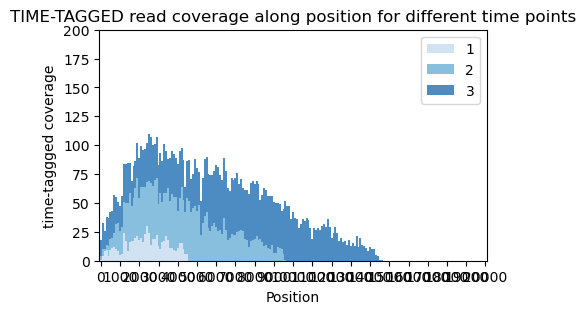

In [7]:
import importlib
importlib.reload(viz)
coverage_df = viz.plot_timeTagged_read_coverage(weibull_exp_list[0:], smooth_N=1, gap_N=100, xaxis_N=10, width=1, stacked=True, ylim=(0,200), xlim=(0,30000), time_to_plot=[1,2,3])

Folow up questions include:
- What is causing the spike in read coverage at the beginning of the gene?
- What is the probability that the fragments pass the length filter given different ways of fragmentation simulation?
- Regardless of how I simulate the fragments, would the method for elongation rate still works?
- Can I somhow simulate the edge effect in a way that still applies the principles of the Weibull distribution proposed by Flux simulator?

Theoretically, below are the questions I would like to answer:
- Why is the uniform fragmentation follow exponential distribution? --> Done
- What is the mean of weibull distribution given the current framework of simulation?
- What is the relationship between beta and exponential, because apparently the way to simulate fragment length by breaking down a stick of length 1 into n pieces is to use beta distribution with parameters 1 and n-1. As n --> inf, beta(1, n-1) is approximately an exponential distribution with rate n. 
- What is the relationship between beta and weibull? 
- Why does the current framework will produce fragments of length following weibull distribution? --> Done
- 

# Relationship between uniform and Weibull and weibull with a scale for the fragment length


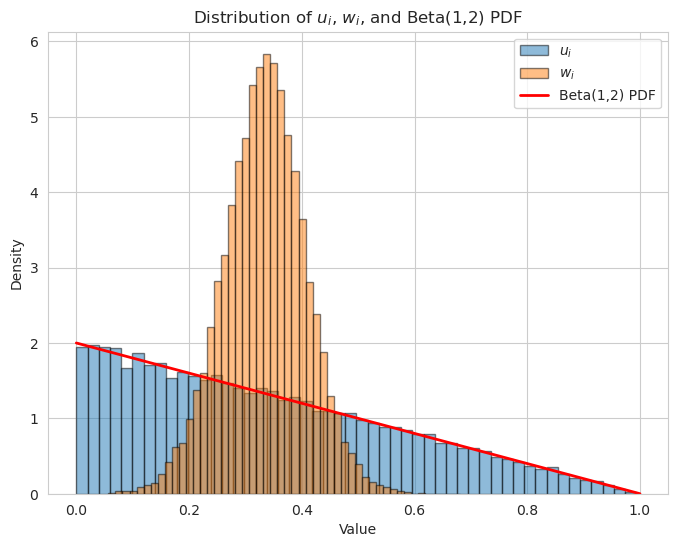

In [3]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
# Re-run the simulations to collect both u_i and w_i values
all_ui = []

# Reset the list for all_wi to ensure it's empty
all_wi = []
num_simulations = 10000
N=3
k=4.47 # log10(30000)
for _ in range(num_simulations):
    # Generate u_i
    u = np.random.dirichlet(np.ones(N), 1).flatten()
    all_ui.extend(u)  # Collect original u_i values
    
    # Transform and normalize to get w_i
    transformed_u = np.power(u, 1/k)
    w = transformed_u / np.sum(transformed_u)
    all_wi.extend(w)

# Define the beta distribution parameters for comparison
a, b = 1, 2
x = np.linspace(0, 1, 1000)
beta_pdf = beta.pdf(x, a, b)

# Plot the histograms and the beta PDF
plt.figure(figsize=(8, 6))
plt.hist(all_ui, bins=50, density=True, alpha=0.5, label='$u_i$', edgecolor='black')
plt.hist(all_wi, bins=50, density=True, alpha=0.5, label='$w_i$', edgecolor='black')
plt.plot(x, beta_pdf, label='Beta(1,2) PDF', linewidth=2, color='red')
plt.title('Distribution of $u_i$, $w_i$, and Beta(1,2) PDF')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


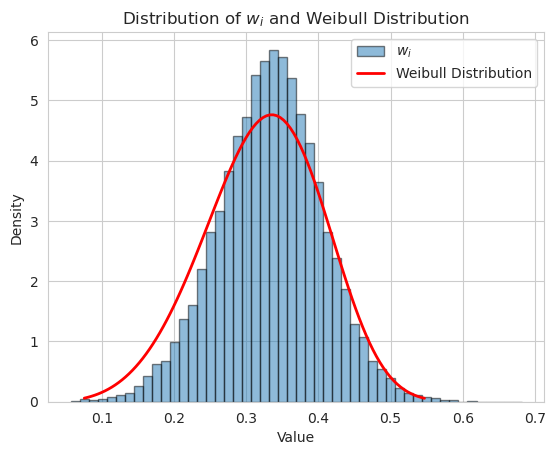

In [11]:
# plot the distribution of w_i and weibull pdf at the same time
from scipy.stats import weibull_min
k=4.47  #shape
scale =0.355 # MLE of the scale parameter of the Weibull distribution given w_i generated like above
x = np.linspace(weibull_min.ppf(0.001, k, scale=scale), weibull_min.ppf(0.999, k, scale=scale), 100)
pdf_values = weibull_min.pdf(x, k, scale = scale)
# plot w_i and the weibull distribution pdf function on the same plot
plt.hist(all_wi, bins=50, density=True, alpha=0.5, label='$w_i$', edgecolor='black')
plt.plot(x, pdf_values, label='Weibull Distribution', linewidth=2, color='red')
plt.title('Distribution of $w_i$ and Weibull Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

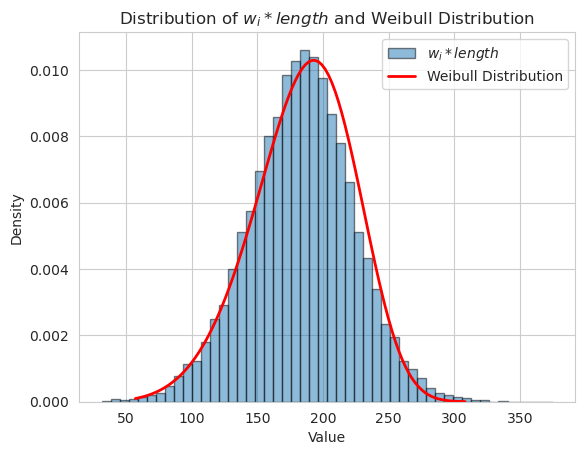

In [19]:
# now transfrom w_i to w_i*length
length = 550
w_i_length = np.array(all_wi) * length
# plot the distribution of w_i*length and the weibull distribution (scale=200, shape=4.47) pdf function on the same plot
plt.hist(w_i_length, bins=50, density=True, alpha=0.5, label='$w_i*length$', edgecolor='black')
new_k = 5.5
x = np.linspace(weibull_min.ppf(0.001, new_k, scale=200), weibull_min.ppf(0.999, k, scale=200), 100)
pdf_values = weibull_min.pdf(x, new_k, scale=200)
plt.plot(x, pdf_values, label='Weibull Distribution', linewidth=2, color='red')
# plot the distribution of w_i*length and the weibull distribution pdf function on the same plot
plt.title('Distribution of $w_i*length$ and Weibull Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


The point is, the procedure of sampling for fragment size right now will do the following:
- Calculate shape k = log10(length)
- Calculate N = length/ (scale * gamma(1+1/k)) --> number of fragments
Note why do they choose k = log10(length) again? It is because when we plot x-axis as length of molecules, and y_axis as scale (default 200) * Gamma(1+1/k), we should see quite a horizontal function. scale*gamma(1+1/k) is the mean of Weibull(scale, shape=k) distribution, so this is saying whatever the length of the  molecule is, we would like the fragment length distribution to have a relatively similar mean.
- Calculate u_i = Dirichlet(1,1,1,...,1) --> N values
- Calculate w_i = u_i^(1/k) / sum(u_i^(1/k)) --> N values
- Calculate w_i * length --> N values
- The N values of w_i * length will be the fragment lengths

This procedure, as we have seen in previous sections, will produce fragment lengths that follow the Weibull distribution. u_i --> w_i changes from beta(1,n-1) to Weibull distribution, and then w_i * length will also follow the Weibull distribution. This is empirical evidence that the Flux Simulator's way of simulating fragment lengths is correct. However, the Flux simulator could have done something more simply which is to simulate fragment lengths by using weibull_min scipy package. Overall this is to understand why the flux simulator is doing what it is doing.

# Edge effect simulation
- The edge effect is the phenomenon where the read coverage is lower at the beginning and the end of the gene compared to the middle of the gene. This is caused by the fact that the fragments at the beginning of the gene can be less likely to pass the length filter compared to the fragments in the middle of the gene.
- It is captured in the following paper: https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-5953-1

In [8]:
# for each transcript, simulate the maximum possible length of the first fragment. Right now, we simulate them as if they are from the Weibull distribution (mean similar to the actual mean of the fragment length distribution)
import importlib
importlib.reload(srt)
trans_length = 30000
frag_length, frag_start = srt.calculate_breakpoints_with_edge_effects(trans_length, eta_val=eta_val, avg_frag_len=-1) #avg_frag_len wont be used in this function

164 164


In [12]:
print(len(frag_length), len(frag_start))
print(frag_length[:3])
print(frag_start[:3])

165 165
[151. 120. 180.]
[  0. 151. 271.]
